![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting numpy data 


- `912*816*2025*float32` Each timestep is 5 GiB.
- 900 timesteps  5T

In [1]:
import os ,sys, time, logging,shutil
from datetime import datetime
import numpy as np

t1 = time.time()
data=np.load("/mnt/data1/DemoNSDF-feb-2023/recon_combined_1_2_3_fullres.npy")
shape,dtype=data.shape,data.dtype
D,H,W=data.shape
m,M=np.min(data),np.max(data)
print(f"np.load done in {time.time()-t1} seconds \ndtype={data.dtype} \nshape={data.shape} \nc_size={W*H*D*4:,} \nm={m} M={M}")

np.load done in 3.9118504524230957 seconds 
dtype=float32 
shape=(2025, 816, 912) 
c_size=6,027,955,200 
m=-0.0024531930685043335 M=0.004590795375406742


# Show a slice along Z

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


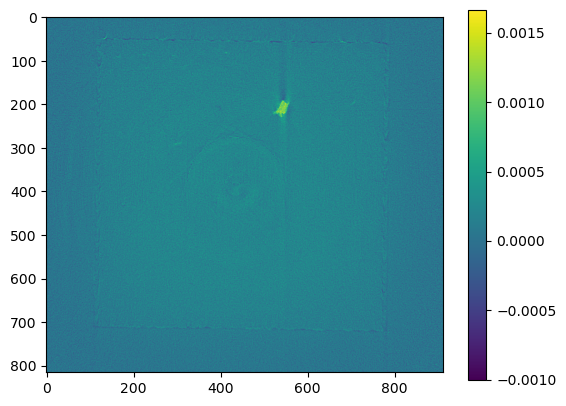

In [2]:
import matplotlib.pyplot as plt
from scipy import ndimage

def ShowData(data,cmap="viridis"):
	print("ShowImage",data.dtype,data.shape,np.min(data),np.max(data))
	plt.imshow(data, cmap=cmap)
	plt.colorbar()
	plt.show()
	
Z=200
slice=data[Z,:,:]
ShowData(slice,cmap="viridis") 

# Import OpenVisus

In [3]:
import OpenVisus as ov
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")
# ov.SetupLogger(logger, output_stdout=True) 
print("OpenVisus imported")

OpenVisus imported


# Create the IDX file

In [4]:
idx_filename="/mnt/data1/nsdf/tmp/recon_combined_1_2_3_fullres/visus.idx"

# ************ dangerous (make sure you are in a tmp directory) ************ 
import os,sys,shutil
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

fields=[ov.Field("data",str(data.dtype),"row_major")]
db=ov.CreateIdx(
	url=idx_filename,
	dims=[W,H,D],
	fields=fields,
	compression="raw")

print(type(db))
print(db.getDatasetBody().toString())

<class 'OpenVisus.dataset.PyDataset'>
<dataset url="/mnt/data1/nsdf/tmp/recon_combined_1_2_3_fullres/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V2012012012012012012012012012012" />
		<box value="0 912 0 816 0 2025" />
		<bitsperblock value="16" />
		<blocksperfile value="512" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="" />
		<field name="data" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="float32" />
		<timestep when="0" />
	</idxfile>
</dataset>


# Write data to OpenVisus

In [5]:
t1 = time.time()
db.write(data)
print(f"db.write done in {time.time() - t1} seconds")

db.write done in 8.019292831420898 seconds


# Compress dataset using zip

In [6]:
t1 = time.time()
db.compressDataset(["zip"])
print(f"db.compressDataset done in {time.time()-t1} seconds")

db.compressDataset done in 33.60554504394531 seconds


# Show OpenVisus data

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


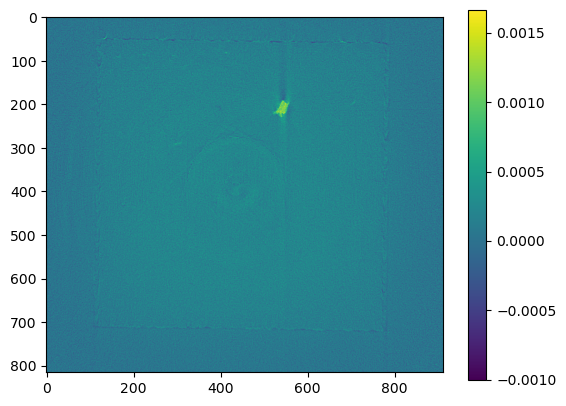

In [7]:
slice=db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=1, quality=0)[0,:,:]
ShowData(slice)

# Show coarse to fine

ShowImage float32 (204, 228) -0.00065949454 0.0014427023


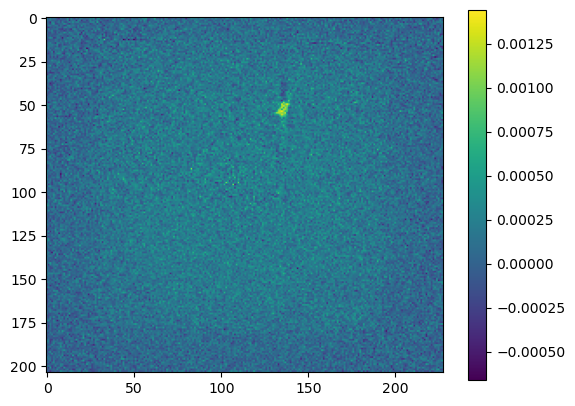

ShowImage float32 (408, 456) -0.0007254779 0.0014807624


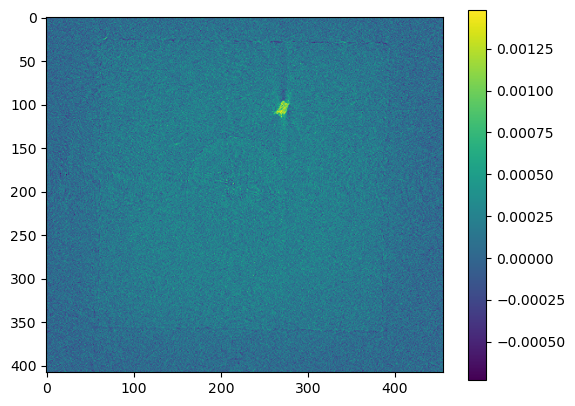

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


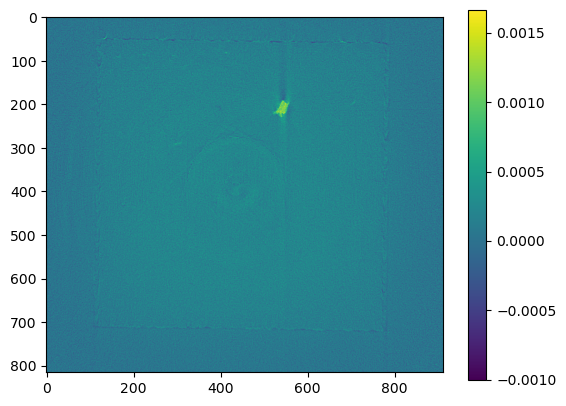

In [8]:
import os,sys
for slice in db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=3, quality=0):
	ShowData(slice[0,:,:])

# Get from OpenVisus server

You need to 

- add the dataset to the `/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config`
- launch the Open Visus server


if you want to enable dynmamic dataset  you can do for example:

```
<visus> 

<Configuration> 
    <ModVisus> 
      <Dynamic enabled="true"  filename="/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config" msec="10000" /> 
    </ModVisus>
</Configuration>

...

</visus>
```

Get credentials to access the OpenVisus server:

In [9]:
username,password=None,None
with open("/nfs/chess/nsdf01/openvisus/.mod_visus.identity.sh","rt") as file:
    for line in file.read().split():
        if "MODVISUS_USERNAME=" in line:
            username=line[line.index("MODVISUS_USERNAME=")+len("MODVISUS_USERNAME="):].strip()
            continue
        if "MODVISUS_PASSWORD=" in line:
            password=line[line.index("MODVISUS_PASSWORD=")+len("MODVISUS_PASSWORD="):].strip()
            continue

ShowImage float32 (816, 912) -0.0010000914 0.0016655645


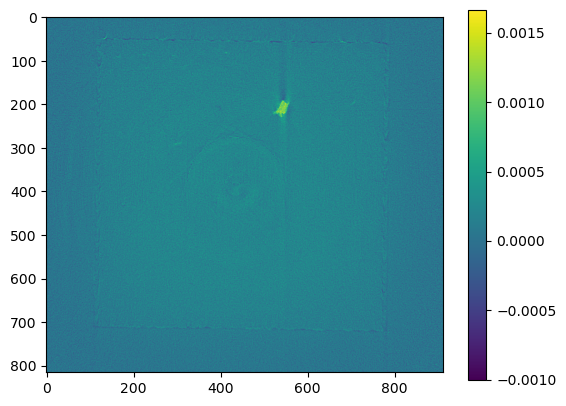

In [10]:
db=ov.LoadDataset(f"https://nsdf01.classe.cornell.edu/mod_visus?dataset=recon_combined_1_fullres&~auth_username={username}&~auth_password={password}")
slice=db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=1, quality=0)[0,:,:]
ShowData(slice)